In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install pymc3>=3.8

In [ ]:
pip install arviz

In [ ]:
pip uninstall pymc3

Uninstalling pymc3-3.11.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pymc3-3.11.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pymc3/*
Proceed (y/n)? y
  Successfully uninstalled pymc3-3.11.2


In [ ]:
pip uninstall arviz

Uninstalling arviz-0.11.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/arviz-0.11.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/arviz/*
Proceed (y/n)? y
  Successfully uninstalled arviz-0.11.2


In [ ]:
%matplotlib inline
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import theano
import pymc3 as pm
import arviz
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

In [ ]:
sns.set_style('whitegrid')

**Data**

The Federal Reserve’s Economic Data (FRED) of the US recession dates as defined by the National Bureau of Economic Research.

Four variables that are commonly used to predict the onset of a recession (Kelley 2019) and available via FRED, namely:

The long-term spread of the treasury yield curve, defined as the difference between the ten-year and the three-month Treasury yield.

The University of Michigan’s consumer sentiment indicator

The National Financial Conditions Index (NFCI), and

The NFCI nonfinancial leverage subindex.

In [ ]:
data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()

In [ ]:
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCILEVERAGE', 'UMCSENT']
var_names = ['recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment']

In [ ]:
features = var_names[1:]
label = var_names[0]

In [ ]:
var_display = ['Recession', 'Yield Curve', 'Financial Conditions', 'Leverage', 'Sentiment']
col_dict = dict(zip(var_names, var_display))

In [ ]:
data = (web.DataReader(indicators, 'fred', 1980, 2020)
        .ffill()
        .resample('M')
        .last()
        .dropna())
data.columns = var_names

In [ ]:
data.loc[:, features] = scale(data.loc[:, features])

In [ ]:

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 1982-01-31 to 2020-01-31
Freq: M
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             457 non-null    float64
 1   yield_curve           457 non-null    float64
 2   financial_conditions  457 non-null    float64
 3   leverage              457 non-null    float64
 4   sentiment             457 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


In [ ]:
mi = []
months = list(range(1, 25))
for month in months:
    df_ = data.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label]))
mi = pd.DataFrame(mi, columns=features, index=months)

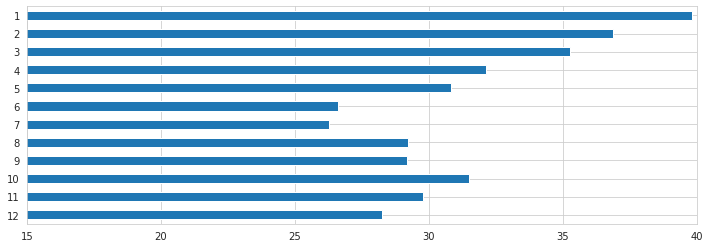

In [ ]:
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

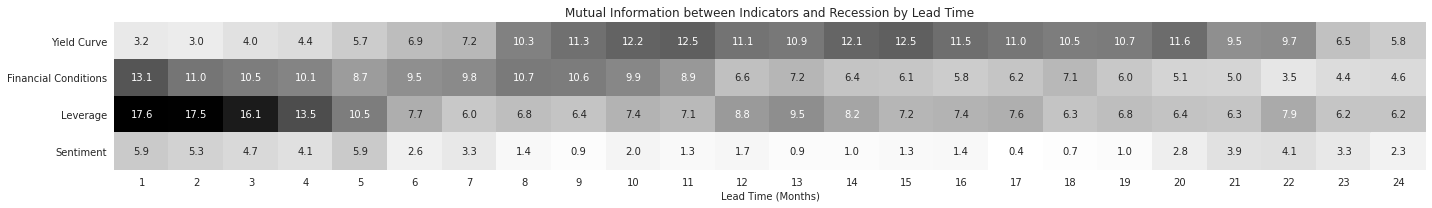

In [ ]:

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(mi.rename(columns=col_dict).T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout();

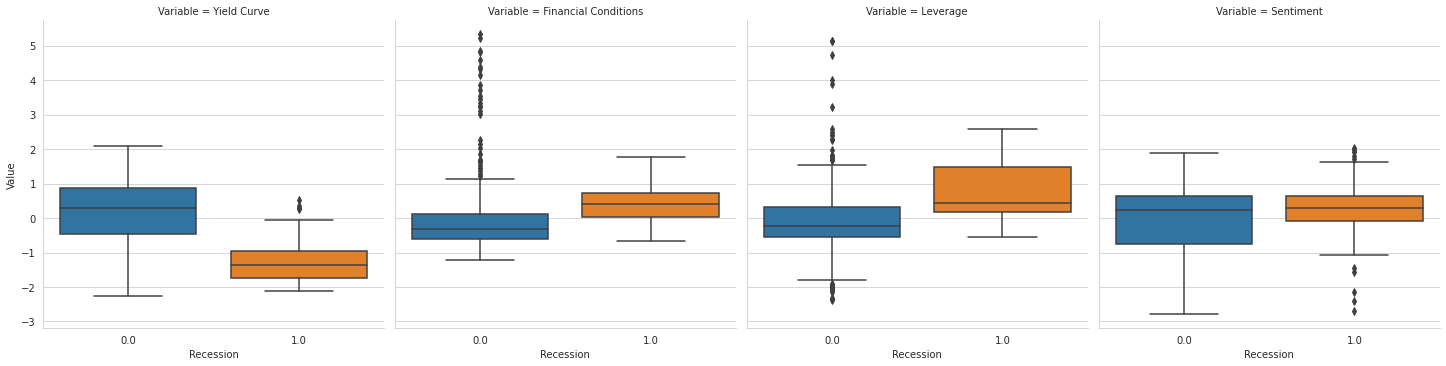

In [ ]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data.rename(columns=col_dict), id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box');

In [ ]:
X = data.loc[:, features]
y = data[label]

In [ ]:
y.value_counts()

0.0    396
1.0     49
Name: recession, dtype: int64

In [ ]:
data.to_csv('data/recessions.csv')

In [ ]:
data = pd.read_csv('data/recessions.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1982-01-31 to 2019-01-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recession             445 non-null    float64
 1   yield_curve           445 non-null    float64
 2   financial_conditions  445 non-null    float64
 3   leverage              445 non-null    float64
 4   sentiment             445 non-null    float64
dtypes: float64(5)
memory usage: 20.9+ KB


In [ ]:
simple_model = 'recession ~ yield_curve + leverage'
full_model =  simple_model + ' + financial_conditions + sentiment'

In [ ]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', 0, sd=100)
    beta_1 = pm.Normal('beta_1', 0, sd=100)
    beta_2 = pm.Normal('beta_2', 0, sd=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + 
                             beta_1 * data.yield_curve +
                             beta_2 * data.leverage)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', 
                 p=likelihood, 
                 observed=data.recession)

In [ ]:
manual_logistic_model.model

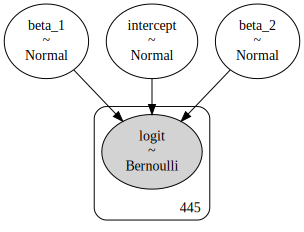

In [ ]:
pm.model_to_graphviz(manual_logistic_model)

In [ ]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

In [ ]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

In [ ]:
print_map(manual_map_estimate)

intercept   -4.825046
beta_1      -2.975726
beta_2       1.482425
dtype: float64

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            data,
                            family=pm.glm.families.Binomial())

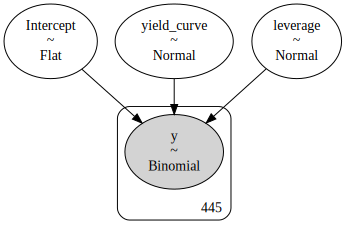

In [ ]:
pm.model_to_graphviz(logistic_model)

In [ ]:
with logistic_model:
    map_estimate = pm.find_MAP()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:
model = smf.logit(formula=simple_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.173942
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  445
Model:                          Logit   Df Residuals:                      442
Method:                           MLE   Df Model:                            2
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                  0.4984
Time:                        10:53:11   Log-Likelihood:                -77.404
converged:                       True   LL-Null:                       -154.30
Covariance Type:            nonrobust   LLR p-value:                 4.008e-34
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.8253      0.594     -8.124      0.000      -5.989      -3.661
yield_curve    -2.9759    

In [ ]:
print_map(map_estimate)

Intercept     -4.825299
yield_curve   -2.975896
leverage       1.482510
dtype: float64

In [ ]:
result.params

Intercept     -4.825282
yield_curve   -2.975877
leverage       1.482497
dtype: float64

In [ ]:
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [ ]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 yield_curve ~ Normal,
 leverage ~ Normal,
 financial_conditions ~ Normal,
 sentiment ~ Normal,
 y ~ Binomial]

In [ ]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8c056f790>,
      dtype=object)

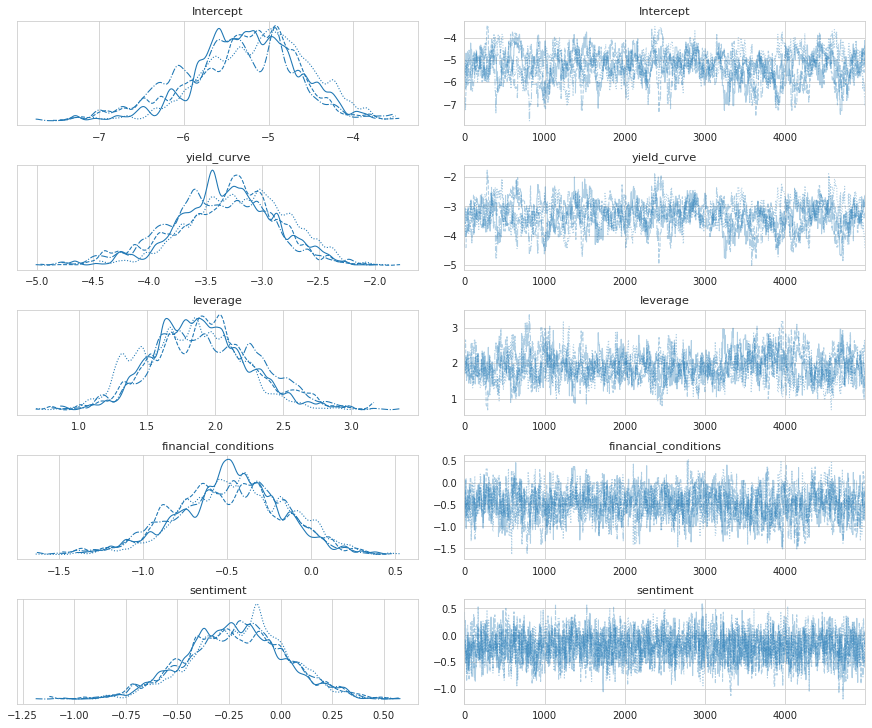

In [ ]:
pm.traceplot(trace_mh)

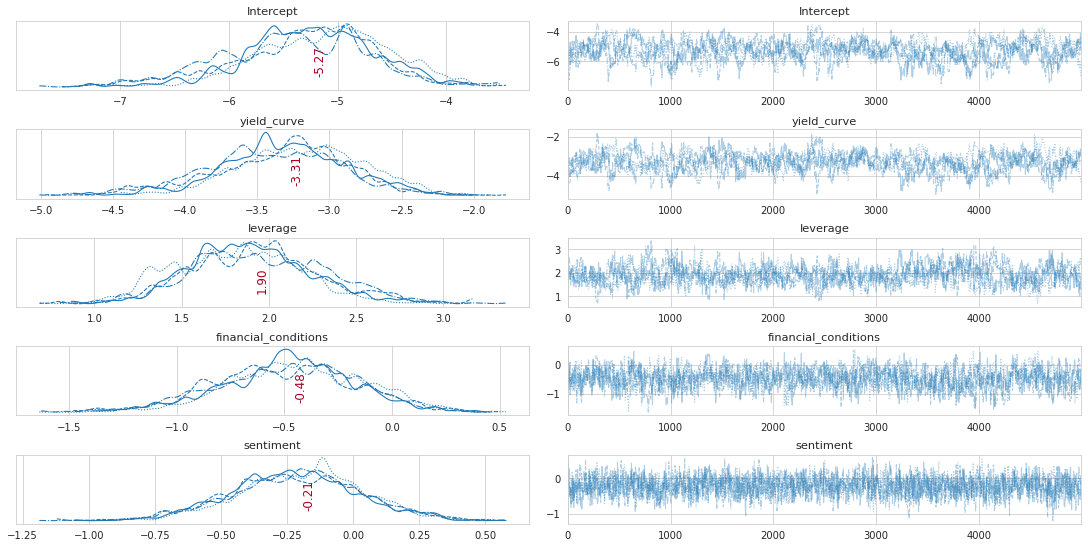

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             20000 non-null  float64
 1   yield_curve           20000 non-null  float64
 2   leverage              20000 non-null  float64
 3   financial_conditions  20000 non-null  float64
 4   sentiment             20000 non-null  float64
dtypes: float64(5)
memory usage: 781.4 KB


In [ ]:
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 2 chains for 1_000 tune and 105_000 draw iterations (2_000 + 210_000 draws total) took 246 seconds.
The number of effective samples is smaller than 10% for some parameters.


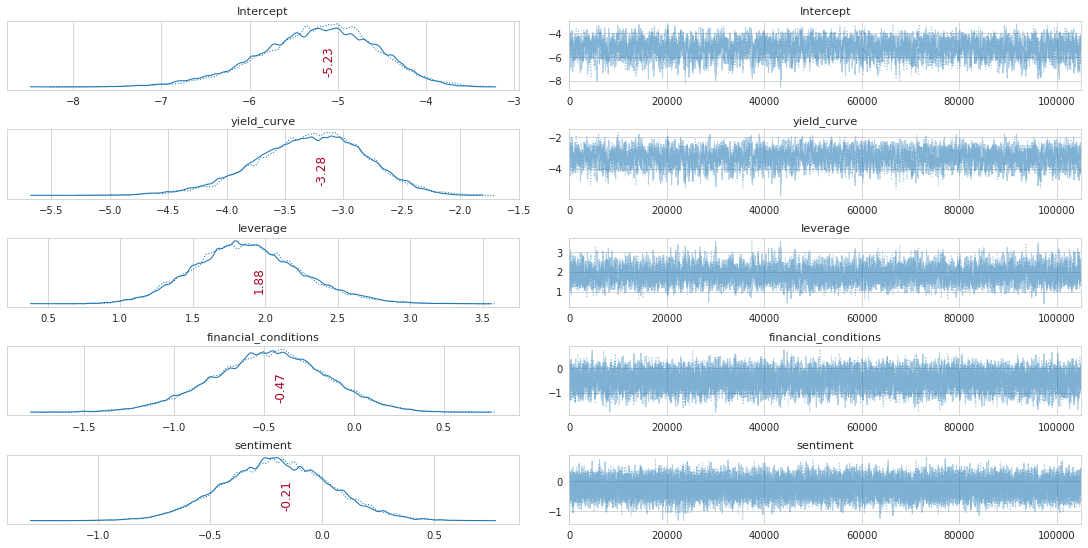

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
arviz.summary(trace_mh)

mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
Intercept            -5.228  0.662  -6.487  ...    1639.0    3314.0    1.0
yield_curve          -3.280  0.473  -4.182  ...    1689.0    3323.0    1.0
leverage              1.881  0.373   1.209  ...    2256.0    4534.0    1.0
financial_conditions -0.473  0.322  -1.084  ...    4748.0    8953.0    1.0
sentiment            -0.208  0.243  -0.677  ...    9763.0   18032.0    1.0

[5 rows x 9 columns]

In [ ]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=1,
                           random_seed=42)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 14 seconds.


In [ ]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             400 non-null    float64
 1   yield_curve           400 non-null    float64
 2   leverage              400 non-null    float64
 3   financial_conditions  400 non-null    float64
 4   sentiment             400 non-null    float64
 5   chain                 400 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.9 KB


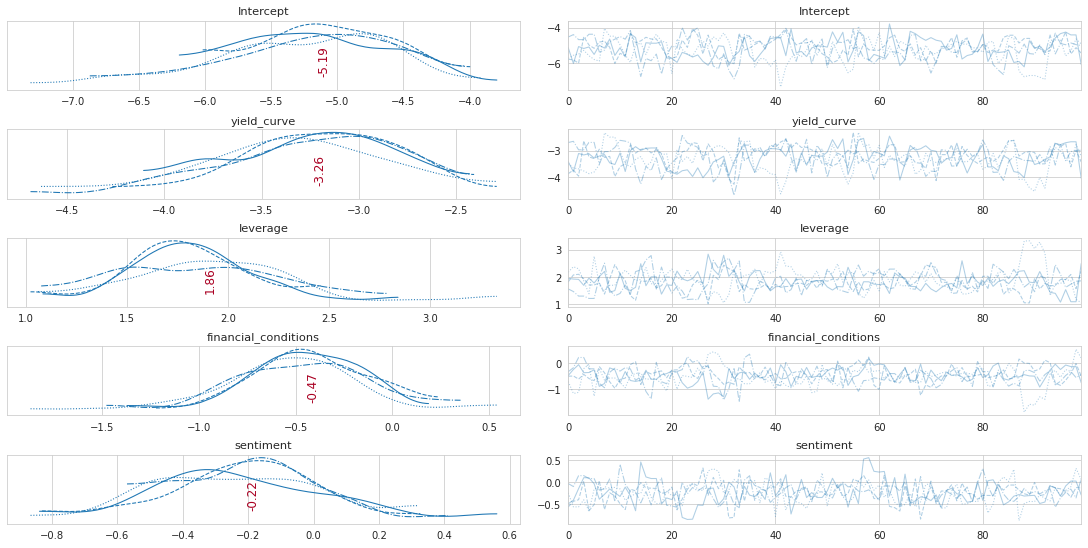

In [ ]:
plot_traces(trace_NUTS, burnin=0)

In [ ]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, 
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains, 
                           cores=1,
                           random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 4 chains for 1_000 tune and 50_100 draw iterations (4_000 + 200_400 draws total) took 540 seconds.


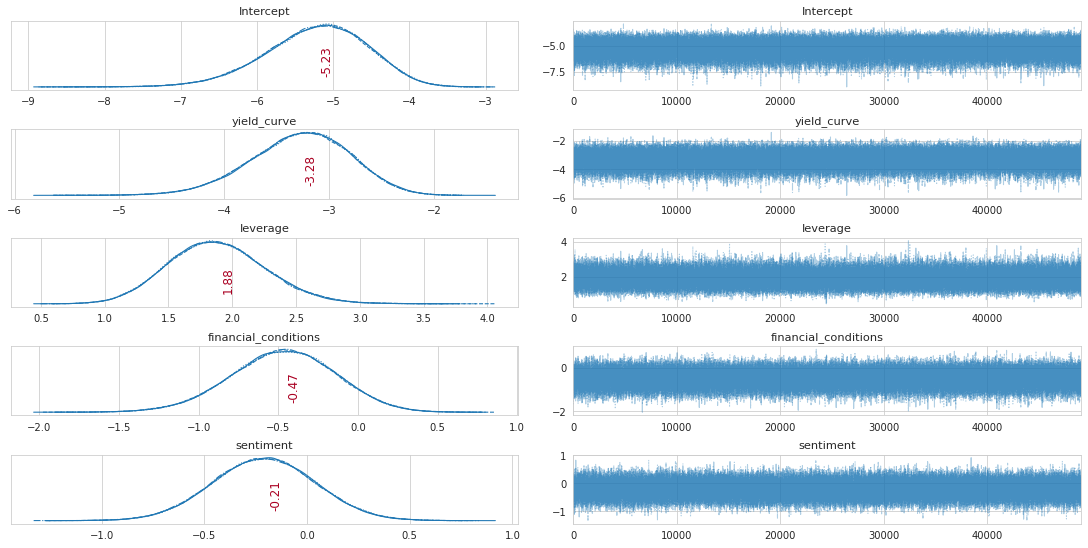

In [ ]:
plot_traces(trace_NUTS, burnin=1000)

In [ ]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200600 entries, 0 to 200199
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Intercept             200600 non-null  float64
 1   yield_curve           200600 non-null  float64
 2   leverage              200600 non-null  float64
 3   financial_conditions  200600 non-null  float64
 4   sentiment             200600 non-null  float64
 5   chain                 200600 non-null  int64  
 6   samples               200600 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 12.2 MB


In [ ]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003000 entries, 0 to 1002999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   samples   1003000 non-null  int64  
 1   chain     1003000 non-null  int64  
 2   variable  1003000 non-null  object 
 3   value     1003000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 30.6+ MB


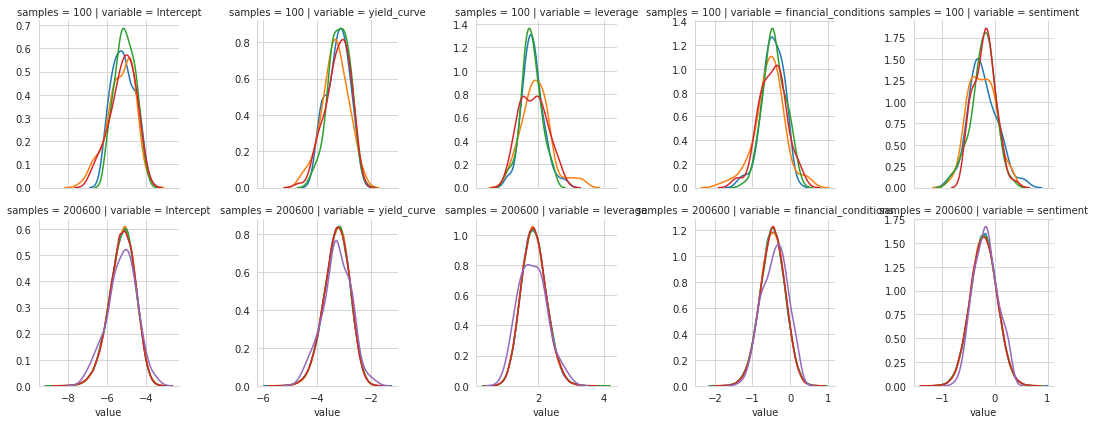

In [ ]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False);

In [ ]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.171670
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  445
Model:                          Logit   Df Residuals:                      440
Method:                           MLE   Df Model:                            4
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                  0.5049
Time:                        12:17:16   Log-Likelihood:                -76.393
converged:                       True   LL-Null:                       -154.30
Covariance Type:            nonrobust   LLR p-value:                 1.151e-32
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.9955      0.630     -7.930      0.000      -6.230      -3.761

In [ ]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

In [ ]:

arviz.summary(trace_NUTS).assign(statsmodels=result.params)

mean     sd  hdi_3%  ...  ess_tail  r_hat  statsmodels
Intercept            -5.228  0.667  -6.485  ...   89986.0    1.0    -4.995516
yield_curve          -3.281  0.477  -4.193  ...   92227.0    1.0    -3.130567
leverage              1.881  0.382   1.166  ...   95214.0    1.0     1.788897
financial_conditions -0.472  0.329  -1.086  ...  108177.0    1.0    -0.432214
sentiment            -0.209  0.250  -0.676  ...  117196.0    1.0    -0.198942

[5 rows x 10 columns]

In [ ]:
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub

In [ ]:
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.014 < Odds Ratio < 0.089) = 0.95


In [ ]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.014 < Odds Ratio < 0.089) = 0.95


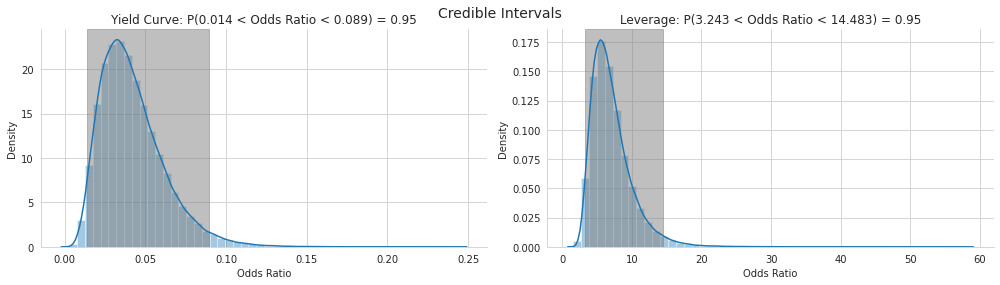

In [ ]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [ ]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000, 
                    callbacks=[callback])

Finished [100%]: Average Loss = 111.74


In [ ]:
trace_advi = approx.sample(10000)

In [ ]:

arviz.summary(trace_advi)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
Intercept            -5.160  0.234  -5.600  ...   10168.0    9879.0    NaN
yield_curve          -3.247  0.181  -3.597  ...    9924.0    9427.0    NaN
leverage              1.844  0.185   1.498  ...    9930.0    9385.0    NaN
financial_conditions -0.453  0.203  -0.839  ...    9852.0    9719.0    NaN
sentiment            -0.204  0.197  -0.581  ...    9864.0    9020.0    NaN

[5 rows x 9 columns]

In [ ]:
arviz.summary(trace_advi).to_csv(model_path / 'trace_advi.csv')

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


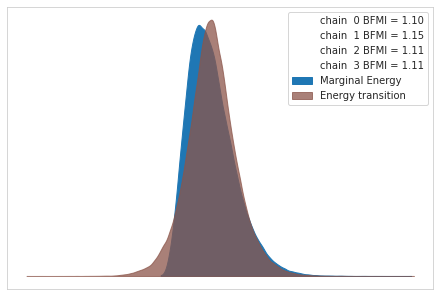

In [ ]:
arviz.plot_energy(trace_NUTS);

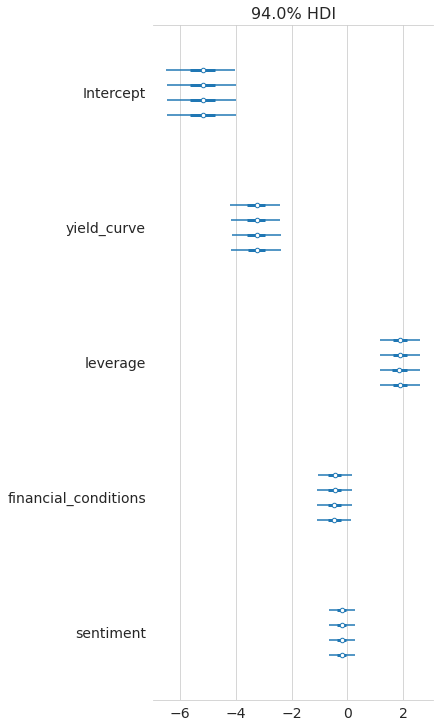

In [ ]:
arviz.plot_forest(trace_NUTS);

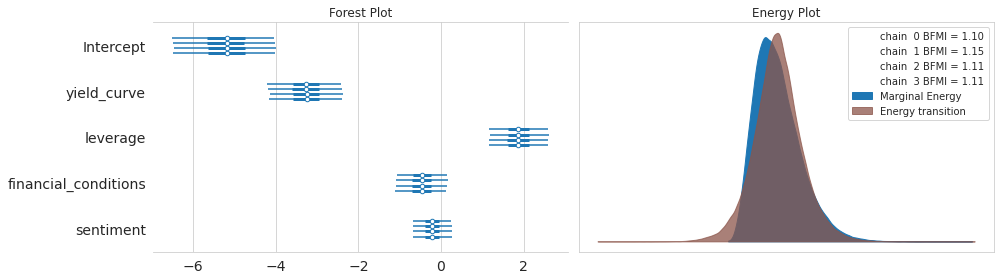

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
arviz.plot_forest(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

arviz.plot_energy(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout();

In [ ]:
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [ ]:
ppc['y'].shape

(500, 445)

In [ ]:
y_score = np.mean(ppc['y'], axis=0)

In [ ]:

roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=data.recession)

0.9494949494949495

In [ ]:
X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
X_shared = theano.shared(X_train.values)

In [ ]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, 
               labels=labels,
               y=y_train, 
               family=pm.glm.families.Binomial())

In [ ]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, 
                           tune=1000,
                           chains=2,
                           cores=1,
                           init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [yield_curve, Intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
X_shared.set_value(X_test)

In [ ]:
ppc = pm.sample_posterior_predictive(pred_trace,
                                     model=logistic_model_pred,
                                     samples=100)

In [ ]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

0.8651898734177216

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

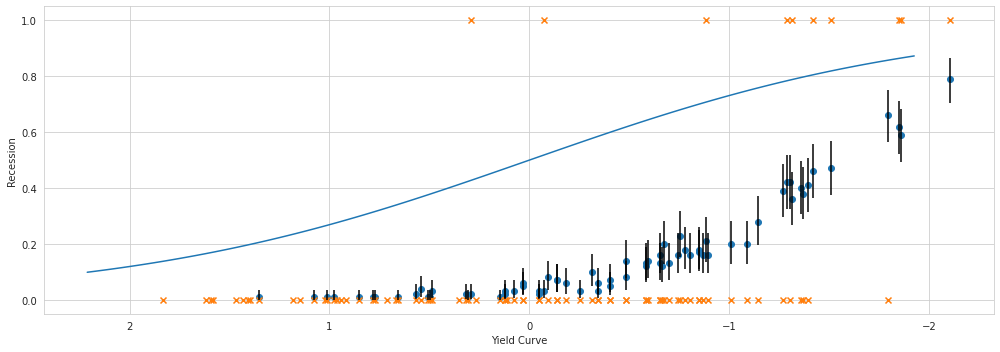

In [ ]:
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout();

In [ ]:
# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

In [ ]:
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

In [ ]:
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)
trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sentiment, financial_conditions, leverage, yield_curve, Intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             1000 non-null   float64
 1   yield_curve           1000 non-null   float64
 2   leverage              1000 non-null   float64
 3   financial_conditions  1000 non-null   float64
 4   sentiment             1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB
None


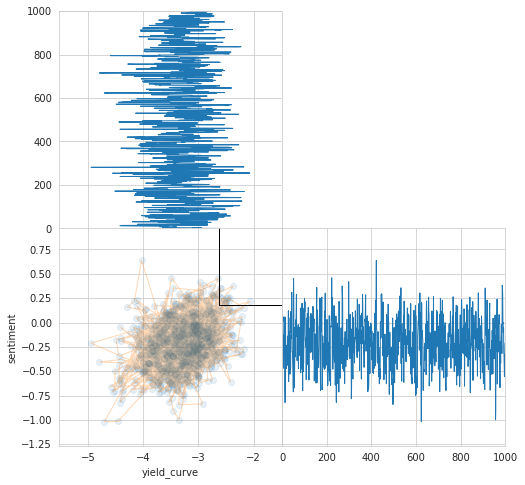

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]


anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True);

# save
# anim.save('nuts.mp4', writer=writer)
# or display; either requres ffmpeg installation
HTML(anim.to_html5_video())

In [ ]:
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sentiment]
>Metropolis: [financial_conditions]
>Metropolis: [leverage]
>Metropolis: [yield_curve]
>Metropolis: [Intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


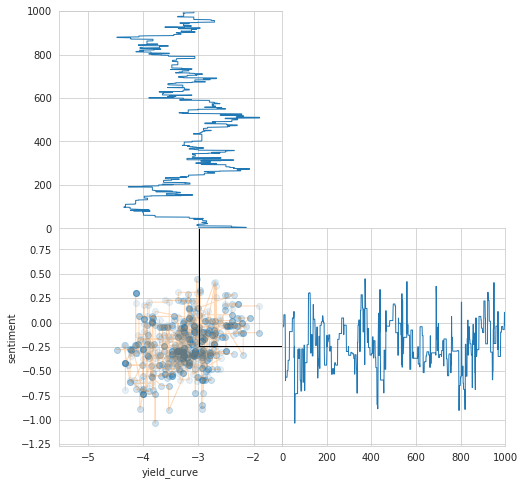

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

HTML(anim.to_html5_video())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')